Image sauvegardée : filtered_images\blur_3x3_rgb.png
Image sauvegardée : filtered_images\blur_5x5_rgb.png
Image sauvegardée : filtered_images\blur_7x7_rgb.png
Image sauvegardée : filtered_images\sharpen_rgb.png
Image sauvegardée : filtered_images\sobel_horizontal_rgb.png
Image sauvegardée : filtered_images\sobel_vertical_rgb.png
Image sauvegardée : filtered_images\random_3x3_rgb.png
Image sauvegardée : filtered_images\random_5x5_rgb.png
Image sauvegardée : filtered_images\random_7x7_rgb.png
Image sauvegardée : filtered_images\sobel_magnitude_gray.png
Image sauvegardée : filtered_images\sobel_horizontal_gray.png
Image sauvegardée : filtered_images\sobel_vertical_gray.png
Image sauvegardée : filtered_images\laplacian_gray.png
Image sauvegardée : filtered_images\prewitt_magnitude_gray.png
Image sauvegardée : filtered_images\prewitt_horizontal_gray.png
Image sauvegardée : filtered_images\prewitt_vertical_gray.png
Image sauvegardée : filtered_images\roberts_gray.png


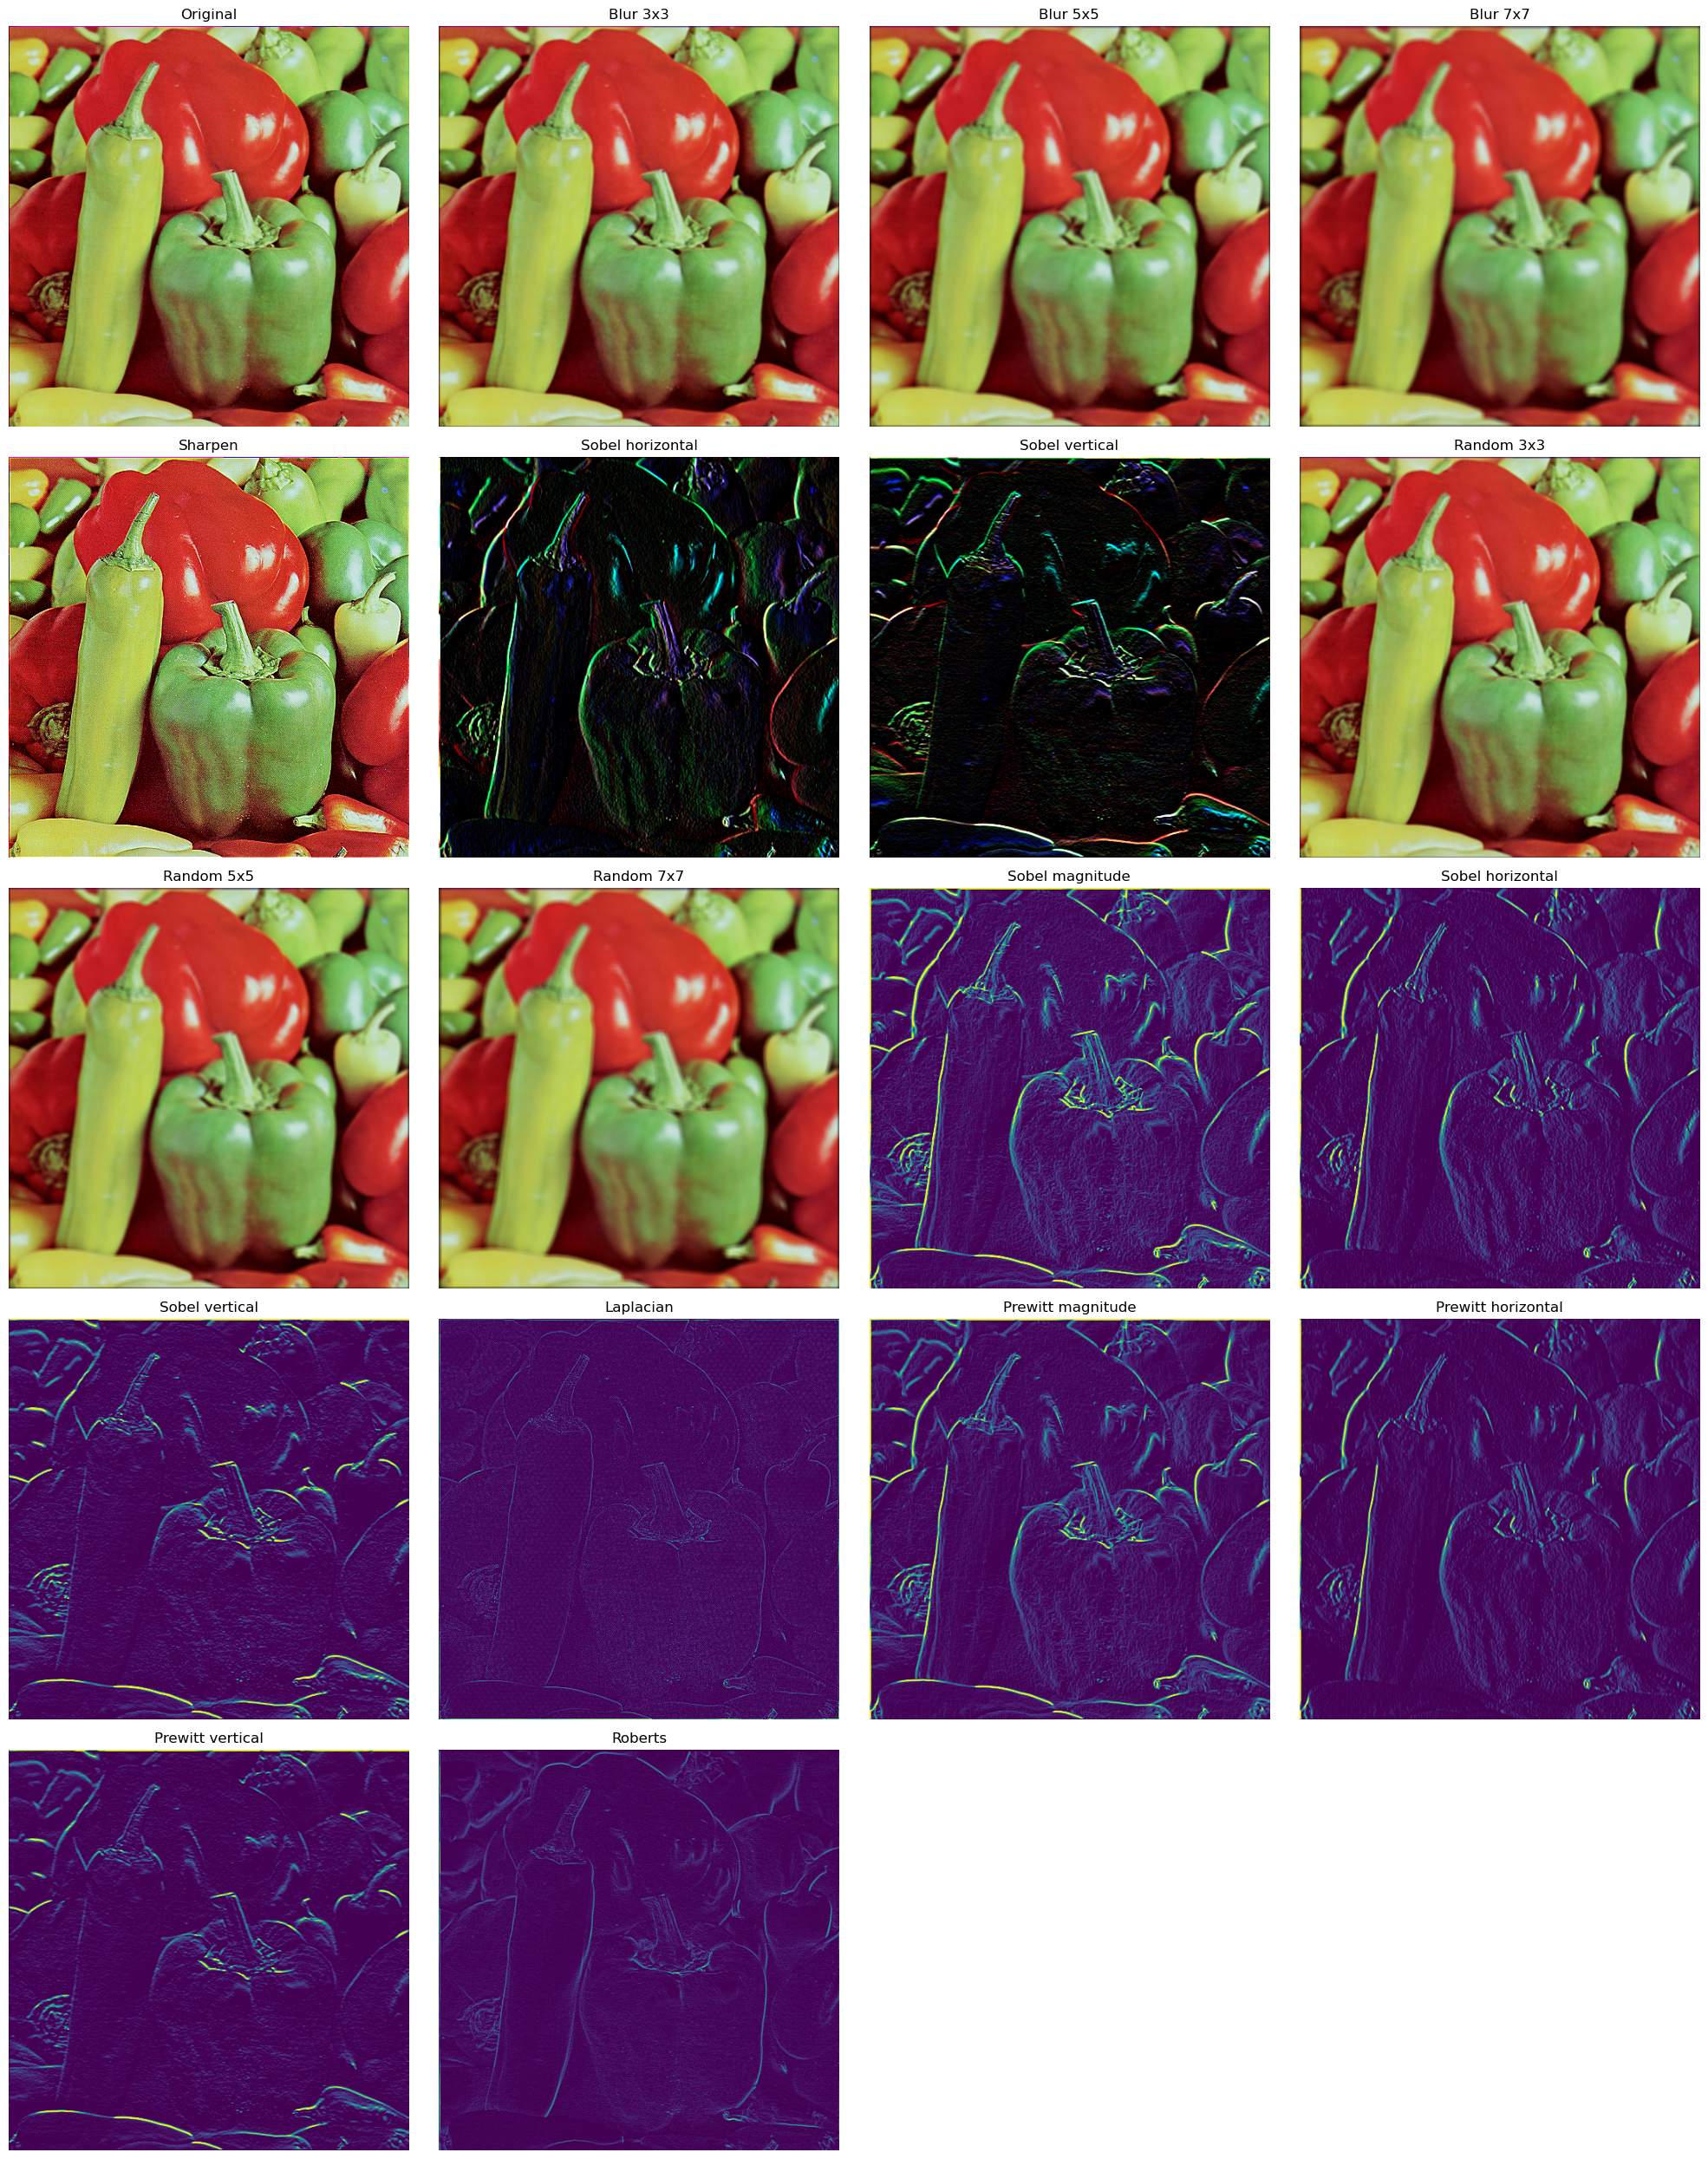

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ---------------------------- #
#      Chargement d'image     #
# ---------------------------- #

def load_image(image_path, force_channel=None):
    """
    Charge une image et détecte automatiquement si elle est en niveaux de gris ou RGB.
    Args:
        image_path (str): Chemin vers l'image.
        force_channel (int, optional): 1 (gris), 3 (RGB), ou None (auto).
    Returns:
        tuple: (image, is_grayscale)
    """
    assert os.path.exists(image_path), f"Fichier introuvable : {image_path}"
    assert image_path.lower().endswith(('.ppm', '.pgm', '.bmp', '.png', '.jpg')), \
        "Format non supporté. Extensions acceptées : .ppm, .pgm, .bmp, .png, .jpg"

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    assert image is not None, f"Échec du chargement de l'image : {image_path}"

    if force_channel is None:
        is_grayscale = len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1)
    else:
        assert force_channel in [1, 3], "force_channel doit être 1 (gris) ou 3 (RGB)"
        is_grayscale = force_channel == 1

    if is_grayscale:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image, is_grayscale

# ---------------------------- #
#     Convolution simple      #
# ---------------------------- #

def apply_kernel_2d(image_channel, kernel):
    """
    Applique une convolution sur une seule couche d'image.
    """
    assert isinstance(image_channel, np.ndarray) and len(kernel.shape) == 2
    kh, kw = kernel.shape
    assert kh == kw and kh % 2 == 1, "Le noyau doit être carré et de taille impaire"

    pad = kh // 2
    padded = np.pad(image_channel, pad, mode='constant')
    result = np.zeros_like(image_channel, dtype=np.float32)

    for i in range(image_channel.shape[0]):
        for j in range(image_channel.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)

    return np.clip(result, 0, 255)

def apply_convolution(image, kernel):
    """
    Applique une convolution à une image (gris ou RGB).
    """
    if image.ndim == 3:  # RGB
        result = np.stack([apply_kernel_2d(image[:, :, c], kernel) for c in range(3)], axis=2)
    else:  # Grayscale
        result = apply_kernel_2d(image, kernel)

    return result.astype(np.uint8)

# ---------------------------- #
#    Détection de contours    #
# ---------------------------- #

def convert_to_grayscale(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8) if image.ndim == 3 else image

def sobel_edges(image):
    """
    Détection de contours via filtre Sobel.
    """
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gray = convert_to_grayscale(image)

    gx = apply_kernel_2d(gray.astype(np.float32), Gx)
    gy = apply_kernel_2d(gray.astype(np.float32), Gy)
    magnitude = np.sqrt(gx**2 + gy**2)

    return np.clip(magnitude, 0, 255).astype(np.uint8), gx.astype(np.uint8), gy.astype(np.uint8)

def laplacian_edges(image):
    """
    Détection via filtre Laplacien.
    """
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    gray = convert_to_grayscale(image)
    result = apply_kernel_2d(gray.astype(np.float32), kernel)
    return np.clip(np.abs(result), 0, 255).astype(np.uint8)

def prewitt_edges(image):
    """
    Détection de contours via Prewitt.
    """
    Gx = np.array([[-1, 0, 1]] * 3)
    Gy = np.array([[-1]*3, [0]*3, [1]*3])
    gray = convert_to_grayscale(image)

    gx = apply_kernel_2d(gray.astype(np.float32), Gx)
    gy = apply_kernel_2d(gray.astype(np.float32), Gy)
    magnitude = np.sqrt(gx**2 + gy**2)

    return np.clip(magnitude, 0, 255).astype(np.uint8), gx.astype(np.uint8), gy.astype(np.uint8)

def roberts_edges(image):
    """
    Détection via Roberts cross-gradient.
    """
    Gx = np.array([[1, 0], [0, -1]])
    Gy = np.array([[0, 1], [-1, 0]])
    Gx_padded = np.pad(Gx, ((0, 1), (0, 1)), mode='constant')
    Gy_padded = np.pad(Gy, ((0, 1), (0, 1)), mode='constant')

    gray = convert_to_grayscale(image)
    gx = apply_kernel_2d(gray.astype(np.float32), Gx_padded)
    gy = apply_kernel_2d(gray.astype(np.float32), Gy_padded)
    magnitude = np.sqrt(gx**2 + gy**2)

    return np.clip(magnitude, 0, 255).astype(np.uint8)

# ---------------------------- #
#  Affichage et sauvegarde    #
# ---------------------------- #

def display_images(images, titles, is_gray=True):
    cols = min(4, len(images))
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(5*cols, 5*rows))
    for idx, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img, cmap='gray' if is_gray else None)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, name, is_gray, folder='filtered_images', fmt='jpg'):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"{name}_{'gray' if is_gray else 'rgb'}.{fmt}")
    if not is_gray and image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    success = cv2.imwrite(path, image)
    assert success, f"Échec de la sauvegarde : {path}"
    print(f"Image sauvegardée : {path}")

# ---------------------------- #
#     Filtres de convolution   #
# ---------------------------- #

def get_kernels():
    np.random.seed(42)
    def normalize(k): return k / k.sum()
    
    return {
        'blur_3x3': np.ones((3, 3)) / 9,
        'blur_5x5': np.ones((5, 5)) / 25,
        'blur_7x7': np.ones((7, 7)) / 49,
        'sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
        'sobel_horizontal': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
        'sobel_vertical': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
        'random_3x3': normalize(np.random.rand(3, 3)),
        'random_5x5': normalize(np.random.rand(5, 5)),
        'random_7x7': normalize(np.random.rand(7, 7)),
    }

# ---------------------------- #
#     Traitement principal     #
# ---------------------------- #

def process_image(path, fmt='jpg', with_edges=True):
    img, is_gray = load_image(path)
    kernels = get_kernels()

    images, titles = [img], ['Original']

    for name, kernel in kernels.items():
        filtered = apply_convolution(img, kernel)
        images.append(filtered)
        titles.append(name.replace('_', ' ').capitalize())
        save_image(filtered, name, is_gray, fmt=fmt)

    if with_edges:
        sobel, gx, gy = sobel_edges(img)
        laplacian = laplacian_edges(img)
        prewitt, pgx, pgy = prewitt_edges(img)
        roberts = roberts_edges(img)

        edge_outputs = [
            (sobel, 'sobel_magnitude'), (gx, 'sobel_horizontal'), (gy, 'sobel_vertical'),
            (laplacian, 'laplacian'), (prewitt, 'prewitt_magnitude'),
            (pgx, 'prewitt_horizontal'), (pgy, 'prewitt_vertical'),
            (roberts, 'roberts')
        ]
        for edge_img, name in edge_outputs:
            images.append(edge_img)
            titles.append(name.replace('_', ' ').capitalize())
            save_image(edge_img, name, True, fmt=fmt)

    display_images(images, titles, is_gray)

# ---------------------------- #
#     Exemple d'exécution      #
# ---------------------------- #

if __name__ == "__main__":
    process_image('pepper.bmp', fmt='png', with_edges=True)
